# Import libraries 

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pymongo import MongoClient
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Screaping injuries data

In [ ]:
# Base URL for scraping
BASE_URL = "https://www.prosportstransactions.com/basketball/Search/SearchResults.php"

# Function to scrape a single page
def scrape_page(start):
    params = {
        'Player': '',
        'Team': '',
        'BeginDate': '',
        'EndDate': '',
        'ILChkBx': 'yes',
        'Submit': 'Search',
        'start': start
    }
    
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()  # Raise an error for bad HTTP responses
    
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'datatable'})
    
    if not table:
        print(f"No table found on page starting at {start}")
        return []

    rows = table.find_all('tr')[1:]  # Skip header row
    data = []

    for row in rows:
        cols = [col.text.strip() for col in row.find_all('td')]
        data.append(cols)

    return data

# Main scraping logic
def scrape_last_season_pages():
    all_data = []
    
    for page in range(1512, 1594 + 1):  # Iterate through pages 1512 to 1612
        start = (page - 1) * 25  # Calculate the correct "start" parameter
        print(f"Scraping page starting at {start}...")
        page_data = scrape_page(start)
        all_data.extend(page_data)

    # Convert to DataFrame
    columns = ["Date", "Team", "Acquired", "Relinquished", "Notes"]
    df = pd.DataFrame(all_data, columns=columns)
    
    # Save to CSV
    df.to_csv("basketball_transactions.csv", index=False)
    print("Data scraping complete. Saved to basketball_transactions.csv.")

# Execute the scraping function
if __name__ == "__main__":
    scrape_last_season_pages()

# Filtering for season 23/24

In [ ]:
# Load the CSV file
transactions_df = pd.read_csv('/Users/mattia/Desktop/DATA_MAN/Progetto/basketball_transactions.csv')

# Determine the indices of the rows to delete
num_rows = len(transactions_df)
rows_to_drop = list(range(19)) + list(range(num_rows - 15, num_rows))

# Keep only the rows that are not to be deleted
filtered_df = transactions_df.drop(rows_to_drop).reset_index(drop=True)

# Save the filtered dataframe, if necessary
filtered_df.to_csv('/Users/mattia/Desktop/DATA_MAN/Progetto/basketball_injuries_24.csv', index=False)

# Database creation and adding variables on MongoDB

In [2]:
# Support functions
def calculate_median_recovery_days(game_dates):
    if len(game_dates) < 2:
        return None
    recovery_days = np.diff(sorted(game_dates))
    return np.median(recovery_days).days

def calculate_total_actions(stats, ts_pct, tov_pct):
    PTS = stats['PTS']
    REB = stats['REB']
    AST = stats['AST']
    STL = stats['STL']
    BLK = stats['BLK']
    TO = stats['TO']

    weighted_pts = PTS * 1
    weighted_reb = REB * 1.125
    weighted_ast = AST * 1.5
    weighted_stl = STL * 1.5
    weighted_blk = BLK * 1.5

    total_actions = weighted_pts * (0.001 + ts_pct) + weighted_reb + weighted_ast + weighted_stl + weighted_blk
    total_actions -= TO * (0.001 + tov_pct)

    return max(total_actions, 1)

def calculate_weighted_efficiency(stats):
    fga = stats['FGA']
    fta = stats['FTA']
    pts = stats['PTS']
    turnovers = stats['TO']

    intensity = fga + (0.44 * fta) + turnovers
    if intensity == 0:
        return 1, 1

    ts_pct = pts / (2 * intensity)
    tov_pct = turnovers / intensity

    return ts_pct, tov_pct

def calculate_difficulty(opponent_points, avg_offensive_rating, point_differential, game_importance):
    if avg_offensive_rating == 0:
        return 1

    if point_differential <= 5:
        point_diff_factor = 1.2
    elif 6 <= point_differential <= 10:
        point_diff_factor = 1.1
    elif 11 <= point_differential <= 14:
        point_diff_factor = 1.0
    else:
        point_diff_factor = 0.9

    return max(point_diff_factor * game_importance, 1e-5)

def calculate_recovery_factor(median_recovery_days, recovery_days):
    if median_recovery_days is None or recovery_days == 0:
        return 1
    return max(median_recovery_days / recovery_days, 1e-5)

# Connection to MongoDB
client = MongoClient('')
db = client['Basketball_24']

# Loading CSV files
players_data = {}
games_file = '/Users/mattia/Desktop/DATA_MAN/Progetto/NBA_players_dataset_24.csv'
injuries_file = '/Users/mattia/Desktop/DATA_MAN/Progetto/basketball_injuries_24.csv'

# Loading and preprocessing game data
game_data = pd.read_csv(games_file)
game_data['game_date'] = pd.to_datetime(game_data['game_date'], errors='coerce')

for _, game in game_data.iterrows():
    player_name = game['player']
    team = game['team']
    age = game['Età']

    if player_name not in players_data:
        players_data[player_name] = {
            'player_name': player_name,
            'team': team,
            'age': age,
            'injuries': [],
            'games': []
        }

    stats = {
        'PTS': game.get('PTS', 0),
        'REB': game.get('REB', 0),
        'AST': game.get('AST', 0),
        'STL': game.get('STL', 0),
        'BLK': game.get('BLK', 0),
        'TO': game.get('TO', 0),
        'FGA': game.get('FGA', 0),
        'FTA': game.get('FTA', 0),
        'FG_PCT': game.get('FG_PCT', 0.0),
    }

    game_date = game['game_date']
    team_score = game.get('team_score', 0)
    opponent_score = game.get('opponent_score', 0)
    previous_game_date = None

    if len(players_data[player_name]['games']) > 0:
        previous_game_date = pd.to_datetime(players_data[player_name]['games'][-1]['date']) if players_data[player_name]['games'] else None

    recovery_days = (game_date - previous_game_date).days if previous_game_date else 1

    ts_pct, tov_pct = calculate_weighted_efficiency(stats)
    total_actions = calculate_total_actions(stats, ts_pct, tov_pct)
    point_differential = abs(team_score - opponent_score)
    difficulty = calculate_difficulty(opponent_score, 115.4, point_differential, 1)

    players_data[player_name]['games'].append({
        'date': game_date.strftime('%Y-%m-%d'),
        'performance_dim': {
            'PTS': stats['PTS'],
            'REB': stats['REB'],
            'AST': stats['AST'],
            'STL': stats['STL'],
            'BLK': stats['BLK'],
            'TO': stats['TO'],
            'FGA': stats['FGA'],
            'FTA': stats['FTA'],
            'FG_PCT': stats['FG_PCT'],
            'TS%': round(ts_pct, 3),
            'TOV%': round(tov_pct, 3),
            'performance': round(total_actions, 2)
        },
        'mp': game.get('mp', 0),
        'difficulty_match': {
            'difficulty': round(difficulty, 2),
            'point_differential': point_differential,
            'team_score': team_score,
            'opponent_score': opponent_score
        },
        'recovery': {
            'recovery_factor': None,  # Temporarily empty
            'recovery_days': recovery_days,
            'median_recovery_days': None  # Temporarily empty
        }
    })

for player_name, player_info in players_data.items():
    # Filter games with 'mp' filled (not NaN)
    valid_games = [game for game in player_info['games'] if pd.notnull(game.get('mp'))]

    # Calculate dates only from valid games
    game_dates = [pd.to_datetime(game['date']) for game in valid_games]

    # Calculate the median recovery days
    median_recovery_days = calculate_median_recovery_days(game_dates)

    # Assign the median and recalculate recovery_days only for valid games
    for i, game in enumerate(player_info['games']):
        if pd.notnull(game.get('mp')):
            if i == 0:  # First valid game
                recovery_days = 1  # No previous games
            else:
                # Find the most recent valid previous game
                previous_valid_game = next(
                    (g for g in player_info['games'][:i][::-1] if pd.notnull(g.get('mp'))), 
                    None
                )
                recovery_days = (pd.to_datetime(game['date']) - pd.to_datetime(previous_valid_game['date'])).days if previous_valid_game else 1

            game['recovery']['recovery_days'] = recovery_days
            game['recovery']['median_recovery_days'] = median_recovery_days
            game['recovery']['recovery_factor'] = calculate_recovery_factor(median_recovery_days, recovery_days)
        else:
            # Leave recovery_days and recovery_factor empty for invalid games
            game['recovery']['recovery_days'] = None
            game['recovery']['recovery_factor'] = None
            game['recovery']['median_recovery_days'] = median_recovery_days

# Loading injury data
injuries_df = pd.read_csv(injuries_file)
injuries_df['Player'] = injuries_df['Acquired'].combine_first(injuries_df['Relinquished']).str.strip('• ')
injuries_df['Notes'] = injuries_df['Notes'].fillna('')
injuries_df['Date'] = pd.to_datetime(injuries_df['Date'], errors='coerce')

for _, row in injuries_df.iterrows():
    player = row['Player']
    notes = row['Notes'].lower()

    if player not in players_data:
        continue

    if "placed on il" in notes:
        start_date = row['Date']
        players_data[player]['injuries'].append({
            'start_date': start_date.strftime('%Y-%m-%d') if pd.notnull(start_date) else None,
            'end_date': None,
            'notes': row['Notes'],
            'duration': None
        })
    elif "activated from il" in notes:
        end_date = row['Date']
        for injury in players_data[player]['injuries']:
            if injury['end_date'] is None:
                injury['end_date'] = end_date.strftime('%Y-%m-%d')
                injury['duration'] = (end_date - datetime.strptime(injury['start_date'], '%Y-%m-%d')).days

# Save data to MongoDB
for player_name, player_info in players_data.items():
    db[player_info['team']].update_one(
        {'player_name': player_info['player_name']},
        {'$set': player_info},
        upsert=True
    )

print("Process completed successfully!")

Process completed successfully!


# Correlation analysis

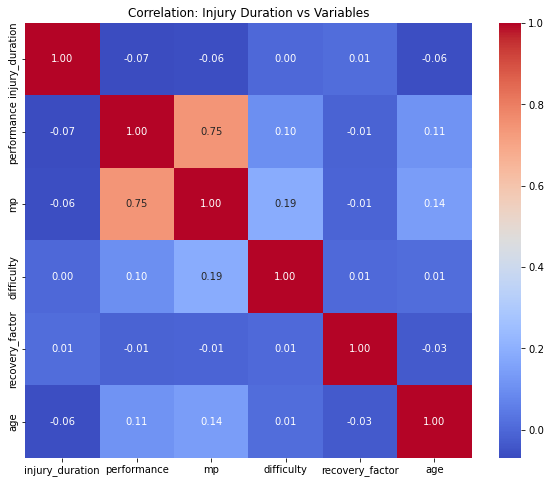

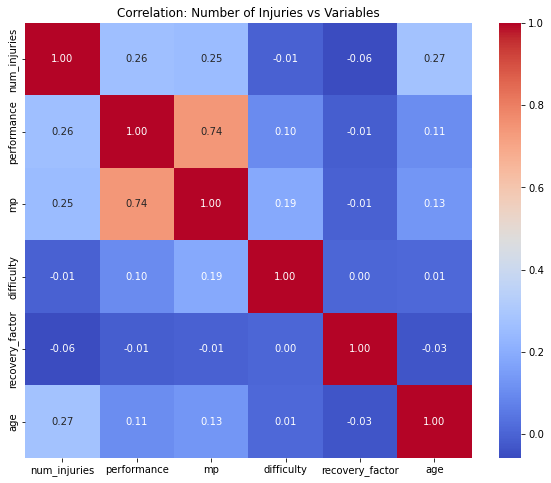

In [3]:
# Connection to MongoDB
client = MongoClient('')
db = client['Basketball_24']

# Extract all data from teams
all_players = []
for team in db.list_collection_names():
    all_players.extend(list(db[team].find()))

# Create the dataset
data = []
for player in all_players:
    player_name = player['player_name']
    age = player['age']
    injuries = player.get('injuries', [])
    num_injuries = len(injuries)
    
    for game in player.get('games', []):
        performance = game['performance_dim']['performance']
        mp = game['mp']
        difficulty = game['difficulty_match']['difficulty']
        recovery_factor = game['recovery']['recovery_factor']
        
        for injury in injuries:
            duration = injury.get('duration')
            data.append({
                'player_name': player_name,
                'age': age,
                'performance': performance,
                'mp': mp,
                'difficulty': difficulty,
                'recovery_factor': recovery_factor,
                'injury_duration': duration,
                'num_injuries': num_injuries,
            })

# Create a DataFrame
df = pd.DataFrame(data)

# Filter valid data (excluding NaN or invalid values)
df_filtered_duration = df.dropna(subset=['injury_duration'])
df_filtered_injuries = df.dropna(subset=['num_injuries'])

# Calculate and visualize correlation (injury duration)
correlation_duration = df_filtered_duration[['injury_duration', 'performance', 'mp', 'difficulty', 'recovery_factor', 'age']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_duration, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Injury Duration vs Variables')
plt.show()

# Calculate and visualize correlation (number of injuries)
correlation_injuries = df_filtered_injuries[['num_injuries', 'performance', 'mp', 'difficulty', 'recovery_factor', 'age']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_injuries, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Number of Injuries vs Variables')
plt.show()

# Linear regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Rimuovi tutte le righe con valori NaN
df_cleaned = df.dropna()

# Separate the independent variables (X) from the dependent variable (y)
X = df_cleaned[['performance', 'mp', 'difficulty', 'recovery_factor', 'age']]
y = df_cleaned['injury_duration']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) and the coefficient of determination (R^2)
print("R^2 (coefficient of determination):", r2_score(y_test, y_pred))
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))

# Analysis of significant variables with the OLS (Ordinary Least Squares) model
X_with_const = sm.add_constant(X_train)  # Add a constant for the intercept
ols_model = sm.OLS(y_train, X_with_const).fit()
print(ols_model.summary())  # Model summary

R^2 (coefficient of determination): 0.008216367907753153
Mean squared error (MSE): 114.16703053512855
                            OLS Regression Results                            
Dep. Variable:        injury_duration   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     65.11
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           5.98e-68
Time:                        11:58:13   Log-Likelihood:            -1.5624e+05
No. Observations:               41010   AIC:                         3.125e+05
Df Residuals:                   41004   BIC:                         3.126e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Rimuovi tutte le righe con valori NaN
df_cleaned = df.dropna()

# Separate the independent variables (X) from the dependent variable (y)
X = df_cleaned[['performance', 'mp', 'difficulty', 'recovery_factor', 'age']]
y = df_cleaned['num_injuries']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) and the coefficient of determination (R^2)
print("R^2 (coefficient of determination):", r2_score(y_test, y_pred))
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred))

# Analysis of significant variables with the OLS (Ordinary Least Squares) model
X_with_const = sm.add_constant(X_train)  # Add a constant for the intercept
ols_model = sm.OLS(y_train, X_with_const).fit()
print(ols_model.summary())  # Model summary

R^2 (coefficient of determination): 0.15401728342620857
Mean squared error (MSE): 4.727273759741544
                            OLS Regression Results                            
Dep. Variable:           num_injuries   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1401.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:58:08   Log-Likelihood:                -89379.
No. Observations:               41010   AIC:                         1.788e+05
Df Residuals:                   41004   BIC:                         1.788e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

# Creation dataset for analysis

In [5]:
# Connection to MongoDB
client = MongoClient('')
db = client['Basketball_24']

# Extract all data from the teams
all_players = []
for team in db.list_collection_names():
    all_players.extend(list(db[team].find()))

# Creating the dataset
data = []
for player in all_players:
    player_name = player.get('player_name', "Unknown")
    injuries = player.get('injuries', [])
    games = player.get('games', [])
    
    # If the player has no games, continue to the next
    if not games:
        continue
    
    # Normalization of performances for each player
    performances = [game['performance_dim']['performance'] for game in games if 'performance_dim' in game and not pd.isna(game['performance_dim'].get('performance'))]

    # If there are no valid performances, skip the player
    if not performances:
        continue
    
    min_performance = min(performances)
    max_performance = max(performances)
    
    # Avoid division by zero if all performances are the same
    normalized_performances = [
        (performance - min_performance) / (max_performance - min_performance) if max_performance != min_performance else 0
        for performance in performances
    ]
    
    # Calculate the mean of the normalized performances
    avg_seasonal_performance = np.mean(normalized_performances)
    
    # Create a dictionary to associate each game with its normalized performance
    games_with_normalized_performance = []
    performance_idx = 0
    for game in games:
        if 'performance_dim' in game and not pd.isna(game['performance_dim'].get('performance')):
            game['normalized_performance'] = normalized_performances[performance_idx]
            games_with_normalized_performance.append(game)
            performance_idx += 1
        else:
            games_with_normalized_performance.append(game)
    
    # Now calculate post-injury performances for each injury
    for injury in injuries:
        start_date = pd.to_datetime(injury['start_date'])
        end_date = pd.to_datetime(injury['end_date']) if injury['end_date'] is not None else None
        duration = injury['duration']
        
        # Classify the injury
        if duration is not None:  # Add a check for None
            if duration > 0 and duration <= 7:
                injury_type = 'short'
            elif duration > 7 and duration <= 30:
                injury_type = 'medium'
            elif duration > 30:
                injury_type = 'long'
        else:
            injury_type = 'unknown'  # If the duration is None, classify it as unknown
        
        # Find the games after the injury ends (only if end_date is present)
        post_injury_games = []
        for game in games_with_normalized_performance:
            game_date = pd.to_datetime(game['date'])
            if end_date is not None and game_date >= end_date and 'normalized_performance' in game:
                post_injury_games.append({
                    'game_date': game_date,
                    'normalized_performance': game['normalized_performance']
                })

        # If there are less than 2 games, take whatever games there are
        post_injury_games = post_injury_games[:2]
        
        # Calculate the mean of post-injury performances
        if post_injury_games:
            performance_post_injury = np.mean([game['normalized_performance'] for game in post_injury_games])
        else:
            performance_post_injury = np.nan  # If there are no games, set to nan
        
        data.append({
            'player_name': player_name,
            'collection': player.get('team', 'Unknown'),
            'injury_type': injury_type,
            'avg_seasonal_performance': avg_seasonal_performance,
            'performance_post_injury': performance_post_injury
        })

# Creating a DataFrame
df_result = pd.DataFrame(data)

# Add a column that calculates the difference between post-injury performance and seasonal average
df_result['performance_difference'] = np.where(
    (pd.notna(df_result['performance_post_injury'])) & (pd.notna(df_result['avg_seasonal_performance'])),
    df_result['performance_post_injury'] - df_result['avg_seasonal_performance'],
    np.nan)  # or another default value you prefer

# Calculate performance_change_percentage avoiding division by zero
df_result['performance_change_percentage'] = np.where(
    df_result['avg_seasonal_performance'] != 0,
    (df_result['performance_difference'] / df_result['avg_seasonal_performance']) * 100,
    0)  # Set to 0 if performance_media_stagionale is zero

# Display the final result
df_result

,player_name,collection,injury_type,avg_seasonal_performance,performance_post_injury,performance_difference,performance_change_percentage
0,Patrick Baldwin Jr.,Wizards,short,0.241840,0.100091,-0.141749,-58.612872
1,Ryan Rollins,Wizards,medium,0.396878,0.303722,-0.093156,-23.472166
2,Eugene Omoruyi,Wizards,short,0.222431,0.033496,-0.188935,-84.940902
3,Eugene Omoruyi,Wizards,medium,0.222431,0.140440,-0.081992,-36.861593
4,Mike Muscala,Wizards,short,0.275373,0.197650,-0.077723,-28.224623
...,...,...,...,...,...,...,...
943,Kentavious Caldwell-Pope,Nuggets,short,0.446795,0.551812,0.105016,23.504384
944,Kentavious Caldwell-Pope,Nuggets,short,0.446795,0.099052,-0.347743,-77.830603
945,Kentavious Caldwell-Pope,Nuggets,medium,0.446795,0.278022,-0.168773,-37.774103
946,Hunter Tyson,Nuggets,short,0.215263,0.012959,-0.202304,-93.979933


# Injuries frequency

Total number of injuries by type:
injury_type
short     593
medium    205
long       54
Name: count, dtype: int64


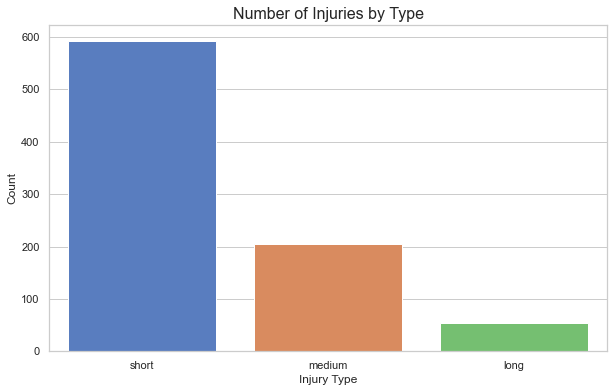

In [15]:
# Set up the chart style
sns.set_theme(style="whitegrid")

# Calculate the total number of injuries for each type
injury_counts = df_result['injury_type'].value_counts().reindex(["short", "medium", "long"], fill_value=0)

# Print the total number of injuries by type
print("Total number of injuries by type:")
print(injury_counts)

# Bar chart: number of injuries by type
plt.figure(figsize=(10, 6))
sns.barplot(x=injury_counts.index, y=injury_counts.values, palette="muted")
plt.title("Number of Injuries by Type", fontsize=16)
plt.xlabel("Injury Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Difference performance post injury

Average performance_difference for short: -5.368662447805392
Average performance_difference for medium: -10.39760739319934
Average performance_difference for long: -24.723509054443625


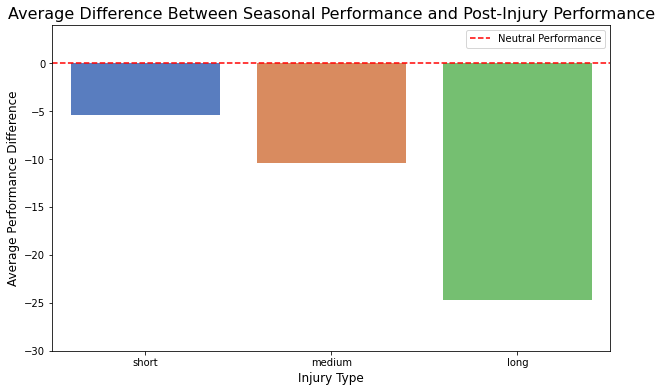

In [9]:
# Filter the DataFrame to exclude 'sconosciuto' (unknown)
df_filtered = df_result[df_result['injury_type'] != 'sconosciuto']

# Calculate the average difference for each injury type
injury_types = ['short', 'medium', 'long']
mean_differences = []

for injury_type in injury_types:
    # Filter the DataFrame for the current injury type
    df_injury_type = df_filtered[df_filtered['injury_type'] == injury_type]
    
    # Calculate the average difference
    mean_difference = df_injury_type['performance_change_percentage'].mean()
    mean_differences.append(mean_difference)
    print(f"Average performance_difference for {injury_type}: {mean_difference}")

# Create a DataFrame for the visualization data
plot_data = pd.DataFrame({
    'injury_type': injury_types,
    'mean_difference': mean_differences
})

# Create a bar chart to visualize the average difference
plt.figure(figsize=(10, 6))
sns.barplot(x='injury_type', y='mean_difference', data=plot_data, palette="muted")
plt.title("Average Difference Between Seasonal Performance and Post-Injury Performance", fontsize=16)
plt.xlabel("Injury Type", fontsize=12)
plt.ylabel("Average Performance Difference", fontsize=12)
plt.axhline(0, color="red", linestyle="--", label="Neutral Performance")
plt.ylim(-30, 4)  # Set the y-axis limits
plt.legend()
plt.show()